### BUSINESS PROBLEM: Your task to build network intrusion detection system to detect anamolies and attacks in the network. There are two problems. 
### 1. Binomial Classification: Activity is normal or attack 

### However, you can use attack variable to define the target variable as required.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [2]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [3]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [6]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [7]:
df_net_test=pd.read_csv('F:/analytix_labs/3. Network Intrusion Detection System/NSL_Dataset/test.txt',sep=',',header = None)

In [8]:
columns=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", 
         "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell",
         "su_attempted","num_root","num_file_creations", "num_shells","num_access_files","num_outbound_cmds",
         "is_host_login", "is_guest_login","count","srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate",
         "same_srv_rate", "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", 
         "dst_host_diff_srv_rate","dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate",
         "dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [9]:
df_net_test.columns=columns

In [10]:
df_net_train=pd.read_csv('F:/analytix_labs/3. Network Intrusion Detection System/NSL_Dataset/train.txt',sep=',',header = None)

In [11]:
df_net_train.columns=columns

In [12]:
df_net_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [13]:
df_net_train.protocol_type.value_counts()

tcp     102689
udp      14993
icmp      8291
Name: protocol_type, dtype: int64

In [14]:
df_net_train.land.value_counts()

0    125948
1        25
Name: land, dtype: int64

In [15]:
### Appending Train and Test and making a new dataframe

In [16]:
df_net=pd.concat([df_net_train,df_net_test])

In [18]:
### spliting data into continuous and catagorical variables

In [17]:
df_net_cat=df_net[['protocol_type','service','flag','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login']]

In [18]:
df_net_cont=df_net.loc[:,df_net.columns.difference(['protocol_type','service','flag','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login'])]

In [16]:
df_net_cont['attack_dum']=np.where(df_net_cont.attack == 'normal', 0, 1)

In [17]:
df_net_cont.drop(columns='attack',inplace = True)

In [18]:
df_net_cat.apply(lambda x : categorical_var_summary(x))

,protocol_type,service,flag,land,logged_in,root_shell,su_attempted,is_host_login,is_guest_login
N,148517,148517,148517,148517.00,148517.00,148517.00,148517.00,148517.00,148517.00
NMISS,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
MODE,tcp,http,SF,0.00,0.00,0.00,0.00,0.00,0.00
FREQ,121569,48191,89820,148485.00,88696.00,148293.00,148433.00,148505.00,146689.00
PERCENT,81.86,32.45,60.48,99.98,59.72,99.85,99.94,99.99,98.77


In [19]:
df_net_cont.apply(lambda x : continuous_var_summary(x))

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,...,same_srv_rate,serror_rate,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,urgent,wrong_fragment,attack_dum
N,1.485170e+05,148517.000000,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,1.485170e+05,...,148517.000000,148517.000000,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000
NMISS,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SUM,1.237690e+07,10063.730000,2.537985e+09,2.731644e+07,12490.730000,20231.030000,21673.420000,79385.400000,38038.440000,1.774224e+07,...,99949.370000,38157.680000,5.974534e+09,4.195893e+06,14471.700000,20567.690000,37921.880000,30.000000,3048.000000,71463.000000
MEAN,8.333656e+01,0.067761,1.708885e+04,1.839280e+02,0.084103,0.136220,0.145932,0.534521,0.256122,1.194627e+02,...,0.672983,0.256925,4.022795e+04,2.825194e+01,0.097441,0.138487,0.255337,0.000202,0.020523,0.481177
MEDIAN,1.300000e+01,0.000000,0.000000e+00,2.550000e+02,0.020000,0.000000,0.000000,0.600000,0.000000,7.200000e+01,...,1.000000,0.000000,4.400000e+01,7.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
STD,1.167607e+02,0.194666,3.703525e+06,9.852833e+01,0.194102,0.322741,0.308638,0.448061,0.428500,1.112323e+02,...,0.436544,0.431918,5.409612e+06,7.536963e+01,0.258886,0.341783,0.432578,0.019417,0.240069,0.499647
VAR,1.363307e+04,0.037895,1.371610e+13,9.707831e+03,0.037676,0.104162,0.095257,0.200759,0.183612,1.237263e+04,...,0.190570,0.186553,2.926390e+13,5.680582e+03,0.067022,0.116816,0.187124,0.000377,0.057633,0.249647
MIN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P1,1.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,...,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P5,1.000000e+00,0.000000,0.000000e+00,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,...,0.010000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
import seaborn as sns

In [32]:
def create_cat_plot(x):
    sns.countplot(x)
    plt.show()

In [33]:
def create_cont_plot(x):
    sns.distplot(x)
    plt.show()

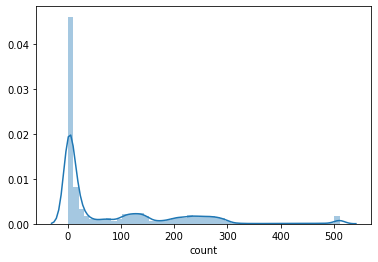

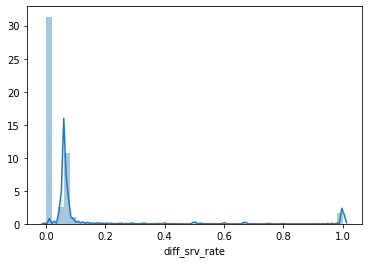

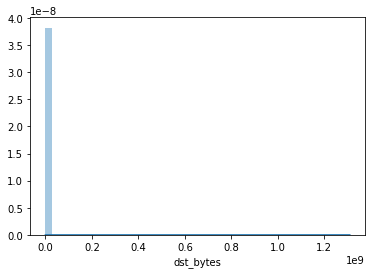

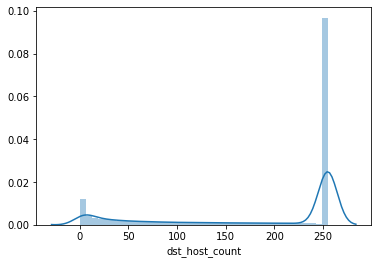

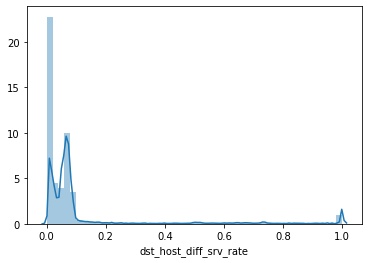

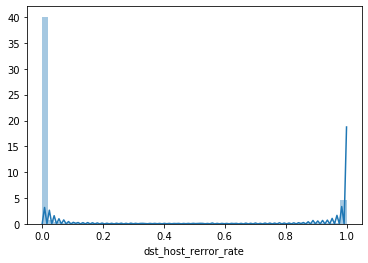

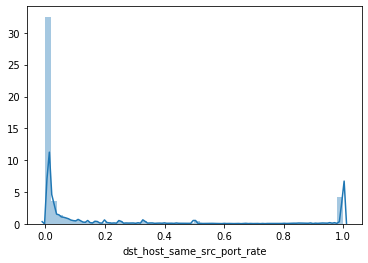

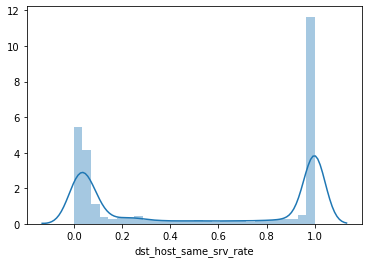

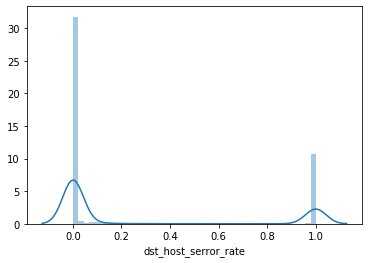

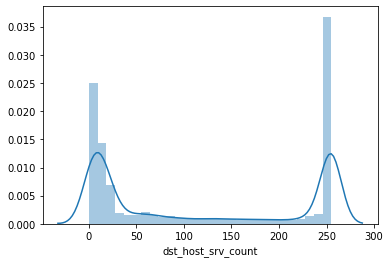

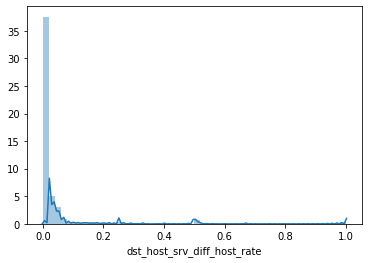

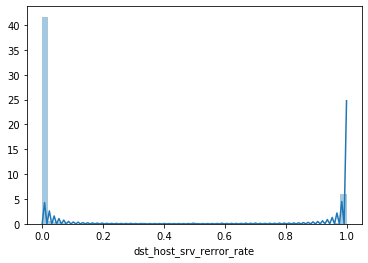

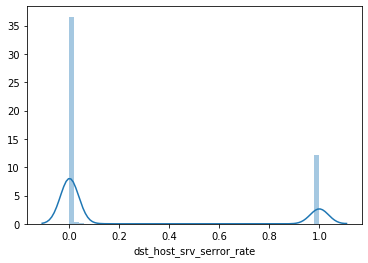

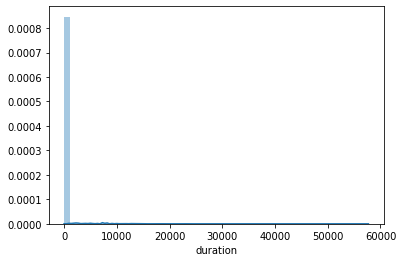

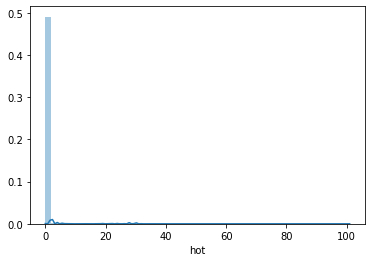

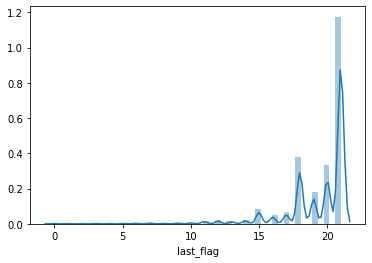

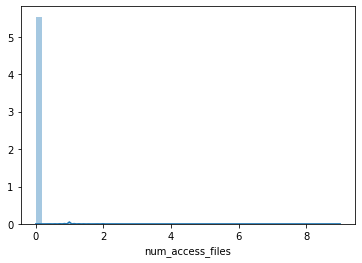

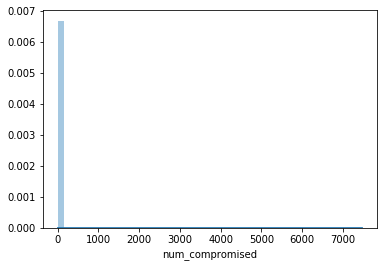

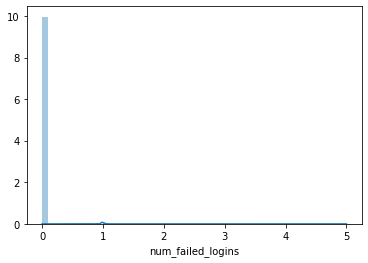

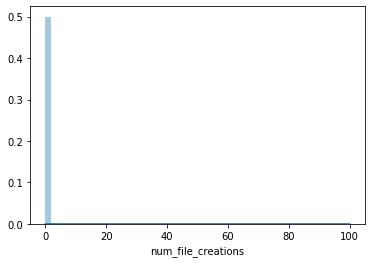

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


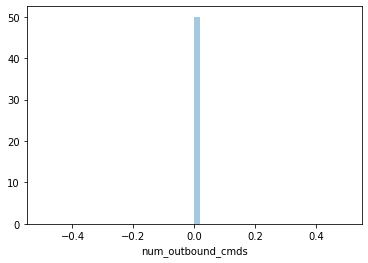

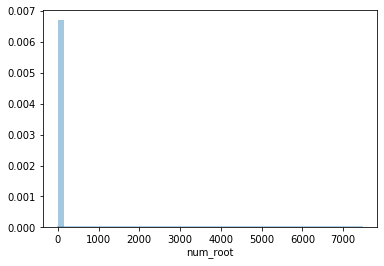

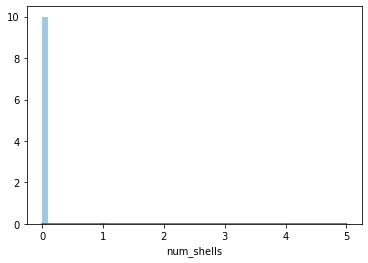

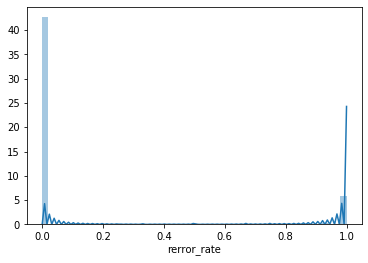

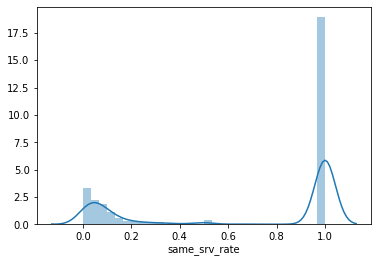

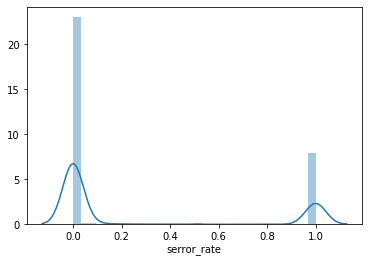

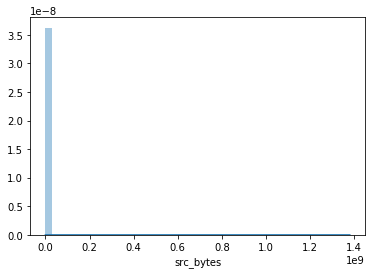

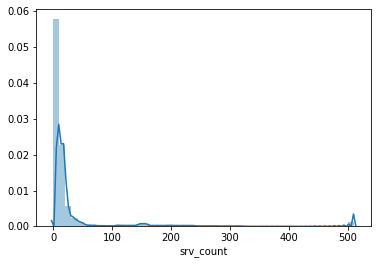

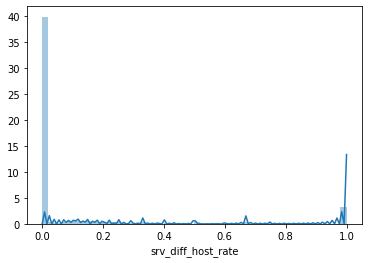

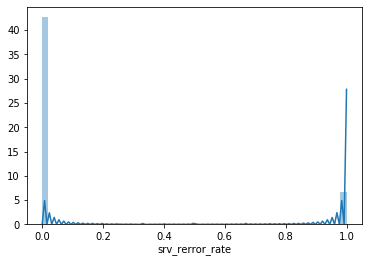

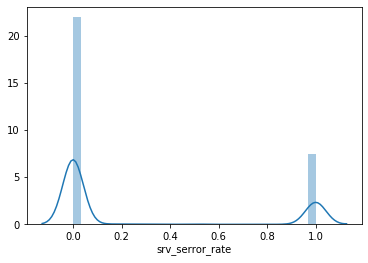

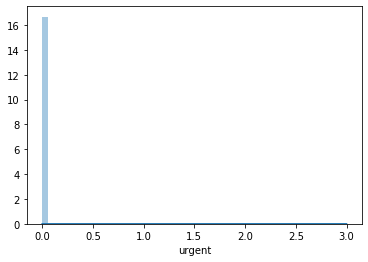

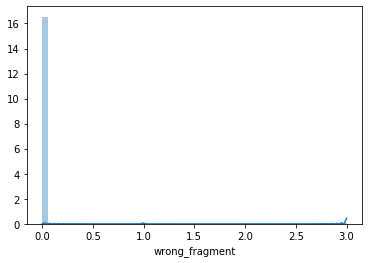

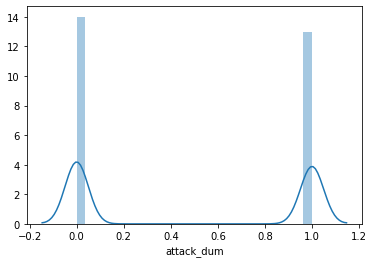

count                          None
diff_srv_rate                  None
dst_bytes                      None
dst_host_count                 None
dst_host_diff_srv_rate         None
dst_host_rerror_rate           None
dst_host_same_src_port_rate    None
dst_host_same_srv_rate         None
dst_host_serror_rate           None
dst_host_srv_count             None
dst_host_srv_diff_host_rate    None
dst_host_srv_rerror_rate       None
dst_host_srv_serror_rate       None
duration                       None
hot                            None
last_flag                      None
num_access_files               None
num_compromised                None
num_failed_logins              None
num_file_creations             None
num_outbound_cmds              None
num_root                       None
num_shells                     None
rerror_rate                    None
same_srv_rate                  None
serror_rate                    None
src_bytes                      None
srv_count                   

In [24]:
df_net_cont.apply(create_cont_plot)

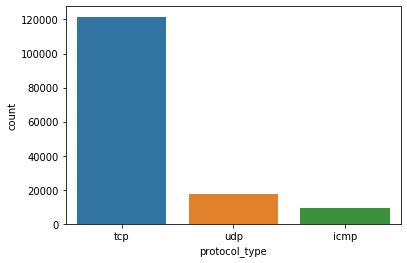

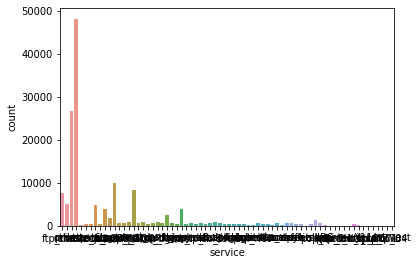

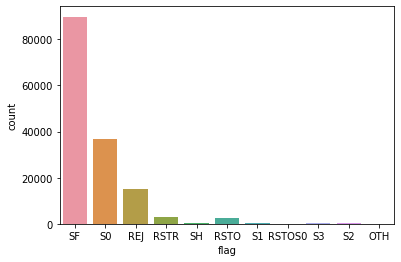

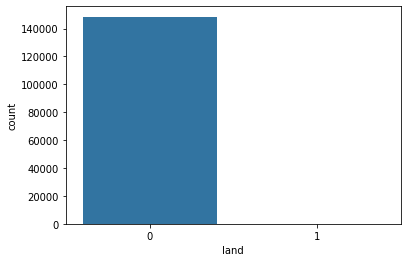

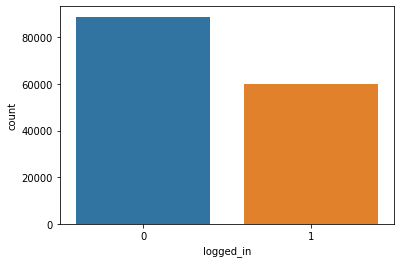

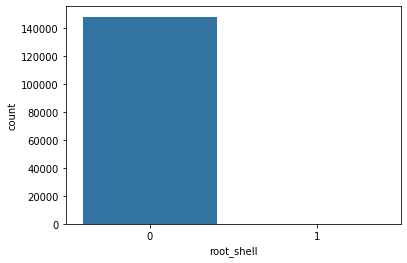

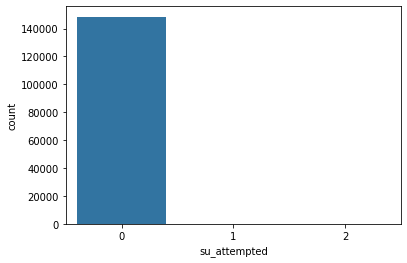

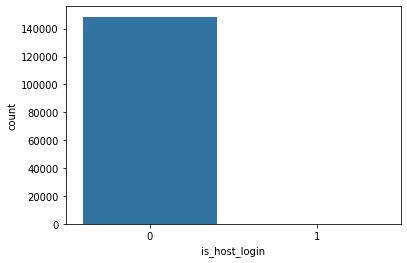

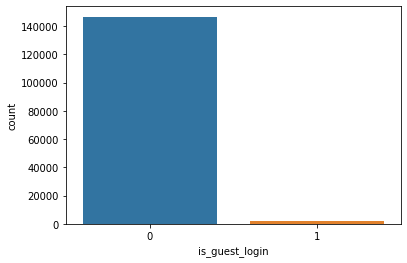

protocol_type     None
service           None
flag              None
land              None
logged_in         None
root_shell        None
su_attempted      None
is_host_login     None
is_guest_login    None
dtype: object

In [141]:
df_net_cat.apply(create_cat_plot)

In [150]:
### Create Dummy variables

In [20]:
df_net_cat.drop(columns='service',inplace= True)

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
# for c_feature in categorical_features
for c_feature in list(df_net_cat.columns):
    df_net_cat[c_feature] = df_net_cat[c_feature].astype('category')
    df_net_cat = create_dummies(df_net_cat, c_feature)


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
net_corr=df_net_cont.corr()

In [28]:
net_corr.to_excel('F:/analytix_labs/3. Network Intrusion Detection System/NSL_Dataset/net_corr.xlsx')

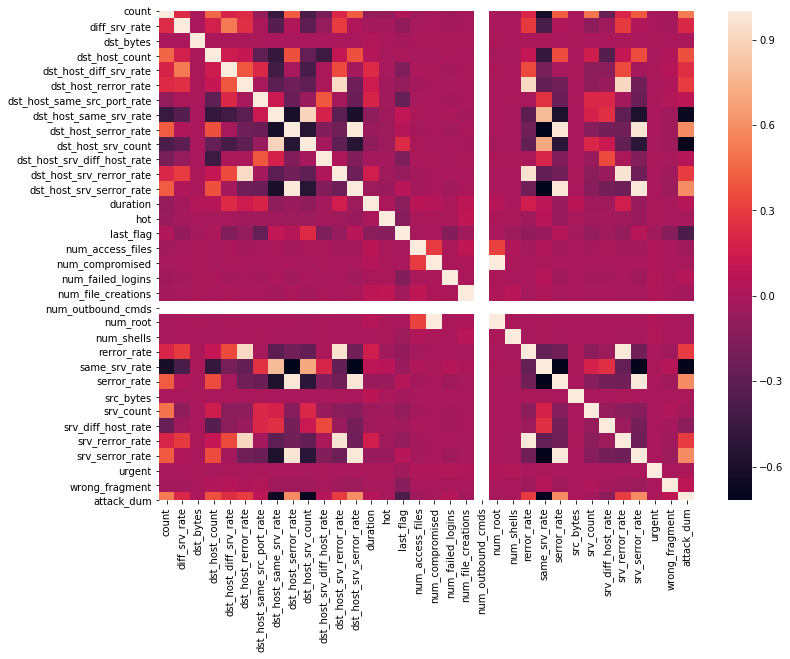

In [38]:
plt.figure(figsize = (12, 9))
sns.heatmap(df_net_cont.corr(), annot= False)

In [2]:
### dropping unnecessary variable 

In [22]:
df_net_cont.drop(columns= 'num_outbound_cmds',inplace= True)

In [23]:
df_net_cont.wrong_fragment.value_counts()

0    147327
3       929
1       261
Name: wrong_fragment, dtype: int64

In [31]:
df_net_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148517 entries, 0 to 22543
Data columns (total 19 columns):
protocol_type_tcp    148517 non-null uint8
protocol_type_udp    148517 non-null uint8
flag_REJ             148517 non-null uint8
flag_RSTO            148517 non-null uint8
flag_RSTOS0          148517 non-null uint8
flag_RSTR            148517 non-null uint8
flag_S0              148517 non-null uint8
flag_S1              148517 non-null uint8
flag_S2              148517 non-null uint8
flag_S3              148517 non-null uint8
flag_SF              148517 non-null uint8
flag_SH              148517 non-null uint8
land_1               148517 non-null uint8
logged_in_1          148517 non-null uint8
root_shell_1         148517 non-null uint8
su_attempted_1       148517 non-null uint8
su_attempted_2       148517 non-null uint8
is_host_login_1      148517 non-null uint8
is_guest_login_1     148517 non-null uint8
dtypes: uint8(19)
memory usage: 3.8 MB


In [106]:
### Building Logistics Model

In [24]:
df_net_new=pd.concat([df_net_cont,df_net_cat], axis = 1)

In [25]:
# Train and Test split
train, test = train_test_split(df_net_new, test_size = 0.3, random_state =  123)

In [26]:
### Generating Feature columns

In [27]:
feature_col =[]

In [28]:
for i in list(train.columns) :
     if i != 'attack_dum':
            feature_col.append(i)
            

In [29]:
# get all the independant variables for model creation
model_param = 'attack_dum ~ ' + ' + '.join(feature_col)

In [30]:
model_param

'attack_dum ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + dst_host_same_src_port_rate + dst_host_same_srv_rate + dst_host_serror_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + dst_host_srv_rerror_rate + dst_host_srv_serror_rate + duration + hot + last_flag + num_access_files + num_compromised + num_failed_logins + num_file_creations + num_root + num_shells + rerror_rate + same_srv_rate + serror_rate + src_bytes + srv_count + srv_diff_host_rate + srv_rerror_rate + srv_serror_rate + urgent + wrong_fragment + protocol_type_tcp + protocol_type_udp + flag_REJ + flag_RSTO + flag_RSTOS0 + flag_RSTR + flag_S0 + flag_S1 + flag_S2 + flag_S3 + flag_SF + flag_SH + land_1 + logged_in_1 + root_shell_1 + su_attempted_1 + su_attempted_2 + is_host_login_1 + is_guest_login_1'

In [31]:
model_param='''attack_dum ~ count + diff_srv_rate + dst_bytes + dst_host_count + 
dst_host_diff_srv_rate + dst_host_same_src_port_rate + dst_host_same_srv_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + duration + hot + last_flag + num_access_files + 
num_failed_logins + num_file_creations + num_root + num_shells + rerror_rate + same_srv_rate + serror_rate + src_bytes + 
srv_count + srv_diff_host_rate  + urgent + wrong_fragment + protocol_type_tcp + 
protocol_type_udp  + flag_RSTO + flag_RSTOS0 + flag_S1 + flag_S2 + flag_S3 + flag_SH + land_1 
+ root_shell_1 + su_attempted_1 + su_attempted_2 + is_host_login_1 + is_guest_login_1
'''

In [40]:
### F_regression to remove multicolinearity

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [42]:

# separate the Y and X variables
y, X = dmatrices(model_param,df_net_new, return_type = 'dataframe')

In [43]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,173.6
1,count,5.1
2,diff_srv_rate,2.0
3,dst_bytes,1.0
4,dst_host_count,2.2
5,dst_host_diff_srv_rate,2.7
6,dst_host_same_src_port_rate,2.3
7,dst_host_same_srv_rate,11.7
8,dst_host_srv_count,8.8
9,dst_host_srv_diff_host_rate,1.8


In [32]:
vif.to_excel('F:/analytix_labs/3. Network Intrusion Detection System/NSL_Dataset/net_vif.xlsx')

NameError: name 'vif' is not defined

In [54]:
m1 = smf.logit(formula = model_param, data = train).fit()

         Current function value: 0.107992
         Iterations: 35


C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [209]:
print(m1.summary())

                           Logit Regression Results                           
Dep. Variable:             attack_dum   No. Observations:               103961
Model:                          Logit   Df Residuals:                   103921
Method:                           MLE   Df Model:                           39
Date:                Mon, 23 Mar 2020   Pseudo R-squ.:                  0.8441
Time:                        15:28:46   Log-Likelihood:                -11227.
converged:                      False   LL-Null:                       -71996.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      10.3963      0.198     52.436      0.000      10.008      10.785
count                           0.0176      0.001     17.885      0.000       0.

In [211]:
# predict the probabilities
p = m1.predict(train)

In [216]:
# get the AUC (Concordance)
metrics.roc_auc_score(train['attack_dum'], p)

0.9919848941766093

In [218]:
# get the meaning of this statement
2 * metrics.roc_auc_score(train['attack_dum'], p) - 1

0.9839697883532186

In [219]:
### get Sommer'D for all X variables

In [239]:
# empty dataframe
somersd_df = pd.DataFrame()

# iterate for each of the X - dependant variables and get the Somer's D value
for num_variable in df_net_new.columns.difference(['attack_dum']):
    
    # execute teh logit model
    logreg = smf.logit(formula = str('attack_dum ~ ') + str(num_variable), data = df_net_new).fit()
    
    # get the predicted probabilities and create a dataframe with the predicted values
    y_score = pd.DataFrame(logreg.predict())
    
    # name the column of the df as score
    y_score.columns = ['Score']
    
    # calculate the Somer's D values
    somers_d = 2 * metrics.roc_auc_score(df_net_new['attack_dum'], y_score) - 1
    
    # place the variable name and the Somers' D score in a temp dataframe
    temp = pd.DataFrame([num_variable, somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    
    # append the data in the dataframe for all the X variables
    somersd_df = pd.concat([somersd_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.516230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.664631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.618243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.446227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479450
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.418808
  

LinAlgError: Singular matrix

In [241]:
somersd_df['Var_Sig']=np.where(somersd_df.SomersD < 0.2 , 'Insig','Sig')

In [242]:
l1=list(somersd_df.loc[somersd_df.Var_Sig == 'Sig','Variable Name'])

In [243]:
model_par= 'attack_dum ~ ' + ' + '.join(l1)

In [244]:
model_par

'attack_dum ~ count + diff_srv_rate + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + dst_host_same_srv_rate + dst_host_serror_rate + dst_host_srv_count + dst_host_srv_rerror_rate + dst_host_srv_serror_rate + flag_S0 + flag_SF + last_flag + logged_in_1 + rerror_rate + same_srv_rate + serror_rate + srv_diff_host_rate + srv_rerror_rate + srv_serror_rate'

In [245]:
m1 = smf.logit(formula = model_par, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.152278
         Iterations 10


In [246]:
print(m1.summary())

                           Logit Regression Results                           
Dep. Variable:             attack_dum   No. Observations:               103961
Model:                          Logit   Df Residuals:                   103940
Method:                           MLE   Df Model:                           20
Date:                Mon, 23 Mar 2020   Pseudo R-squ.:                  0.7801
Time:                        16:21:22   Log-Likelihood:                -15831.
converged:                       True   LL-Null:                       -71996.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    8.7239      0.246     35.499      0.000       8.242       9.206
count                        0.0052      0.000     41.680      0.000       0.005       0.

In [252]:
# predict the values on training and testing
train['pred_prob'] = m1.predict(train)
train_predict = m1.predict(train)
test_predict = m1.predict(test)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [254]:
train.attack_dum.mean()

0.48236357864968593

In [237]:
metrics.roc_auc_score(train['attack_dum'], p)

0.9857563371040389

In [255]:
metrics.accuracy_score( train['attack_dum'],
                            train_predict>0.482)

0.9480189686517059

In [257]:
# model performance | Method 1: AUC
train_auc = metrics.roc_auc_score(train['attack_dum'], train_predict)
test_auc = metrics.roc_auc_score(test['attack_dum'], test_predict)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.9857563371040389
The AUC for the model built on the Test Data is :  0.9853729806769636


In [261]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)
train_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
train_pf = pd.concat([train['attack_dum'], train_predicted_prob], axis = 1)
train_pf.columns = ['actual', 'prob']

In [262]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)
test_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
test_pf = pd.concat([test['attack_dum'], test_predicted_prob], axis=1)
test_pf.columns = ['actual','prob']

test_pf.head()

,actual,prob
87015,0,0.005509
101991,1,0.998836
22048,1,0.995612
1371,0,0.146673
34176,1,0.995136


In [264]:
test_pf['predicted'] = test_pf['prob'].apply(lambda x: 1 if x > 0.482 else 0)
train_pf['predicted'] = train_pf['prob'].apply(lambda x: 1 if x > 0.482 else 0)

In [266]:
# confusion matrix of training dataset
pd.crosstab(train_pf['actual'], train_pf['predicted'])

predicted,0,1
actual,,
0,51313,2501
1,2903,47244


In [267]:
# confusion matrix of testing dataset
pd.crosstab(test_pf['actual'], test_pf['predicted'])

predicted,0,1
actual,,
0,22216,1024
1,1256,20060


In [268]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.9480189686517059
The overall accuracy score for the Test Data  is :  0.9488284406140587


### 2. Multinomial classification: Activity is normal or DOS or PROBE or R2L or U2R Please note that, currently the dependent variable (target variable) is not definied explicitly. 

 Note : I have tried using different ML and statistical techniques to solve this problem and checked the accuracy in each case.

1) Using Multinomial Logistics Regression :--- Accuracy : 84%

2) Using OnevsRest Classifier  :--- Accuracy : 94%

3) Using Decision Trees  :--- Accuracy : 98.6%

4) Using Random Forest  :--- Accuracy : 99.87%

In [19]:
import sklearn.tree as dt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.model_selection import GridSearchCV

In [20]:
df_net=pd.concat([df_net_train,df_net_test])

In [21]:
def create_dum_attack(x):
    if x =='normal': 
        return 0 # Normal
    elif x in ['back' ,'land','pod','neptune','smurf','teardrop','apache2','udpstorm','processtable','worm'] : 
        return 1 # Dos
    elif x in ['satan','ipsweep','nmap','portsweep','mscan','saint'] :
        return 2 # probe
    elif x in ['guess_passwd','ftp_write','imap' ,'phf','multihop','warezmaster' ,'warezclient','spy',
               'xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named','mailbomb'] :
        return 3 #U2L
    elif x in ['buffer_overflow','loadmodule','rootkit','perl','ps','sqlattack','xterm']:
        return 4 #U2R

In [22]:
### Create Dummy for Attack Variable

In [23]:
df_net['attack_dum']=df_net.attack.apply(create_dum_attack)
df_net.attack_dum=df_net.attack_dum.astype('int64')

In [24]:
df_net.drop(columns='attack',inplace=True)

In [25]:
### Breaking data into continuos and categorical

In [26]:
df_net_cat=df_net[['protocol_type','service','flag','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login']]

In [27]:
df_net_cont=df_net.loc[:,df_net.columns.difference(['protocol_type','service','flag','land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login'])]

In [28]:
### Create Dummy for categorical Variable

In [29]:
# for c_feature in categorical_features
for c_feature in list(df_net_cat.columns):
    df_net_cat[c_feature] = df_net_cat[c_feature].astype('category')
    df_net_cat = create_dummies(df_net_cat, c_feature)


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
### Building MultiClassification model using Decision Tree

In [31]:
df_net_new=pd.concat([df_net_cont,df_net_cat], axis = 1)

In [32]:
#Splitting the data

feature_columns = df_net_new.columns.difference( ['attack_dum'] )
#feature_columns1 = feature_columns

In [33]:
feature_columns

Index(['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count',
       'dst_host_diff_srv_rate', 'dst_host_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'dst_host_srv_count',
       ...
       'service_whois', 'src_bytes', 'srv_count', 'srv_diff_host_rate',
       'srv_rerror_rate', 'srv_serror_rate', 'su_attempted_1',
       'su_attempted_2', 'urgent', 'wrong_fragment'],
      dtype='object', length=121)

In [34]:
from sklearn.model_selection import train_test_split


train_X, test_X, train_y, test_y = train_test_split( df_net_new[feature_columns],
                                                  df_net_new['attack_dum'],
                                                  test_size = 0.3,
                                                  random_state = 555 )

### Using Multinomial Logistic Regression

In [35]:
# Building Models
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class = 'multinomial',solver = 'newton-cg')


In [36]:
logreg.fit( train_X, train_y)

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
logreg.predict(train_X)

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [38]:
logreg.predict_proba(train_X)

array([[4.40507050e-04, 9.38368384e-01, 6.11911087e-02, 3.75593631e-16,
        3.89181155e-10],
       [9.27709671e-01, 9.46298427e-03, 5.71751286e-02, 5.62694886e-03,
        2.52672451e-05],
       [7.51245495e-01, 2.97818042e-02, 2.03076974e-01, 1.55146416e-02,
        3.81084889e-04],
       ...,
       [9.68613881e-01, 2.59085612e-02, 5.47679160e-03, 7.62741003e-07,
        3.04245573e-09],
       [2.99088514e-01, 3.76459521e-01, 2.62890666e-01, 6.00698486e-02,
        1.49145076e-03],
       [9.68125325e-01, 2.86651684e-02, 3.20950620e-03, 3.83553508e-12,
        1.81937826e-12]])

In [39]:
list( zip( feature_columns, logreg.coef_[0] ) )

[('count', 0.015959488665221545),
 ('diff_srv_rate', -0.002772070544993404),
 ('dst_bytes', 4.811112053447758e-06),
 ('dst_host_count', -0.0024799465395153246),
 ('dst_host_diff_srv_rate', -0.007876164844626827),
 ('dst_host_rerror_rate', -0.03640906942001534),
 ('dst_host_same_src_port_rate', -0.10361285635258222),
 ('dst_host_same_srv_rate', -0.05330537217971583),
 ('dst_host_serror_rate', -0.05270938326436053),
 ('dst_host_srv_count', 0.010447966831086722),
 ('dst_host_srv_diff_host_rate', -0.04210125286824398),
 ('dst_host_srv_rerror_rate', -0.03792504192426455),
 ('dst_host_srv_serror_rate', -0.05668084858611729),
 ('duration', 3.700214487959897e-05),
 ('flag_REJ', -0.011965213927814876),
 ('flag_RSTO', -0.004897942350027963),
 ('flag_RSTOS0', -9.934224167497448e-05),
 ('flag_RSTR', -0.025081652683179755),
 ('flag_S0', -0.05638068758096965),
 ('flag_S1', 0.002728988513236601),
 ('flag_S2', 0.00033201275270557264),
 ('flag_S3', -0.00319429423888395),
 ('flag_SF', 0.0489364800205814

In [40]:
#Predicting the test cases
net_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': logreg.predict( test_X ) } )

In [47]:
net_test_pred=net_test_pred.reset_index()

,level_0,index,actual,predicted
0,0,17079,1,1
1,1,16406,1,1
2,2,93872,0,0
3,3,120413,0,0
4,4,45773,2,1
...,...,...,...,...
44551,44551,28854,1,1
44552,44552,2567,1,1
44553,44553,5479,3,3
44554,44554,21277,2,1


In [42]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix( net_test_pred.actual,
                            net_test_pred.predicted)
cm

array([[22592,   468,    27,    20,     0],
       [ 1436, 14389,    82,    19,     0],
       [ 2123,  1786,   288,    28,     0],
       [  885,   138,    12,   225,     0],
       [   17,     2,     4,    15,     0]], dtype=int64)

In [43]:
#pd.crosstab(net_test_pred.actual, net_test_pred.predicted)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

Text(0.5, 15.0, 'Predicted label')

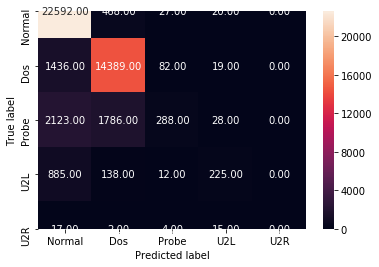

In [45]:
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Normal", "Dos","Probe","U2L","U2R"] , yticklabels = ["Normal", "Dos","Probe","U2L","U2R"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [49]:
score = metrics.accuracy_score( net_test_pred.actual, net_test_pred.predicted )
round( float(score), 2 )

0.84

In [174]:
### Conslusion : Multinomial Logistics Regression using SkLearn yielded 84% accuracy.

In [50]:
#How good the model is?
predict_proba_df = pd.DataFrame( logreg.predict_proba( test_X ) )
predict_proba_df.head()

,0,1,2,3,4
0,0.207287,0.748837,0.043567,2.944835e-04,1.405057e-05
1,0.000364,0.944633,0.055003,1.898498e-18,1.573132e-11
2,0.933075,0.016538,0.033493,1.689230e-02,1.909451e-06
3,0.934218,0.043947,0.012350,9.484500e-03,6.641530e-08
4,0.355413,0.407140,0.155033,8.040673e-02,2.007522e-03


In [51]:
net_test_pred = pd.concat( [net_test_pred, predict_proba_df], axis = 1 )

In [175]:
#net_test_pred.columns  = ['index', 'actual', 'predicted', 'attack_normal', 'attack_dos','attack_probe','attack_u2l','attack_u2r']
#net_test_pred['new_pred']=net_test_pred[['attack_normal', 'attack_dos','attack_probe','attack_u2l','attack_u2r']].idxmax(axis=1)
#net_test_pred['pred_n']=np.where(net_test_pred.new_pred =='attack_normal',0,np.where(net_test_pred.new_pred =='attack_dos',1,np.where(net_test_pred.new_pred =='attack_probe',2,np.where(net_test_pred.new_pred =='attack_u2l',3,4))))

In [53]:
#import required set of libraries
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
#from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

### Using OneVsRest Classifier

In [137]:
# classifier model
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(train_X,train_y)
pred_y=y_score.decision_function(test_X)



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

In [142]:
pred_y=pd.DataFrame(pred_y)

In [144]:
net_test_pred = pd.concat( [net_test_pred, pred_y], axis = 1 )

In [151]:
net_test_pred.rename(columns={0: 'attack_normal_c',1: 'attack_dos_c',2: 'attack_probe_c',3: 'attack_u2l_c',4: 'attack_u2r_c'},inplace = True)


In [155]:
net_test_pred['new_pred_c']=net_test_pred[['attack_normal_c', 'attack_dos_c','attack_probe_c','attack_u2l_c','attack_u2r_c']].idxmax(axis=1)
net_test_pred['pred_c']=np.where(net_test_pred.new_pred_c =='attack_normal_c',0,np.where(net_test_pred.new_pred_c =='attack_dos_c',1,np.where(net_test_pred.new_pred_c =='attack_probe_c',2,np.where(net_test_pred.new_pred_c =='attack_u2l_c',3,4))))

In [177]:
net_test_pred[['actual','predicted','pred_n','pred_c']]

,actual,predicted,pred_n,pred_c
0,1,1,1,1
1,1,1,1,1
2,0,0,0,0
3,0,0,0,0
4,2,1,1,2
...,...,...,...,...
44551,1,1,1,1
44552,1,1,1,1
44553,3,3,3,3
44554,2,1,1,2


In [229]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix( net_test_pred.actual,
                            net_test_pred.pred_c)
cm

array([[21403,  1110,   238,   352,     4],
       [  127, 15658,    54,    87,     0],
       [  122,   284,  3782,    37,     0],
       [  216,   108,     2,   931,     3],
       [   29,     0,     1,     8,     0]], dtype=int64)

In [231]:
#pd.crosstab(net_test_pred.actual,net_test_pred.pred_c)

In [232]:
score = metrics.accuracy_score( net_test_pred.actual, net_test_pred.pred_c )
round( float(score), 2 )

0.94

In [180]:
### Conclusion: Using OneVsRest Classifier the accuracy yielded is 94%

### Using Decision Trees

In [181]:
### Tuning the paramters

In [182]:
param_grid = {'max_depth': np.arange(2, 12),
             'max_features': np.arange(10,18)}

In [183]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 10,verbose=1,n_jobs=-1)
tree.fit( train_X, train_y )

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                         'max_features': array([10

In [184]:
tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=17, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [185]:
train_pred = tree.predict(train_X)

In [186]:
print(metrics.classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     53947
           1       1.00      1.00      1.00     37168
           2       0.99      0.98      0.99      9852
           3       0.94      0.90      0.92      2913
           4       0.88      0.27      0.42        81

    accuracy                           0.99    103961
   macro avg       0.96      0.83      0.86    103961
weighted avg       0.99      0.99      0.99    103961



In [187]:
test_pred = tree.predict(test_X)

In [188]:
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23107
           1       1.00      1.00      1.00     15926
           2       0.98      0.98      0.98      4225
           3       0.94      0.89      0.91      1260
           4       0.47      0.18      0.26        38

    accuracy                           0.99     44556
   macro avg       0.88      0.81      0.83     44556
weighted avg       0.99      0.99      0.99     44556



In [187]:
### Building Final Tree Model

In [189]:
clf_tree = DecisionTreeClassifier( max_depth = 11, max_features=17)
clf_tree.fit( train_X, train_y )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
                       max_features=17, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [190]:
clf_tree.feature_importances_

array([2.04505228e-02, 2.12108494e-02, 7.53277446e-03, 9.90912009e-04,
       1.25553201e-02, 3.59058700e-03, 6.74746726e-02, 5.80668914e-03,
       3.38166875e-03, 2.74172401e-02, 7.10537644e-03, 1.84260454e-03,
       3.05667269e-02, 3.04206118e-03, 3.16810850e-05, 1.94532978e-05,
       9.98565730e-06, 0.00000000e+00, 2.79597895e-03, 4.97556725e-05,
       1.11161702e-05, 1.48877279e-05, 1.32115772e-02, 5.52025383e-03,
       9.01725985e-04, 4.61507959e-05, 0.00000000e+00, 1.21689033e-04,
       4.29912461e-02, 1.84775827e-03, 0.00000000e+00, 0.00000000e+00,
       5.75641103e-04, 1.55636299e-05, 0.00000000e+00, 5.55808510e-07,
       0.00000000e+00, 3.16114727e-02, 8.14198190e-03, 1.59266429e-02,
       0.00000000e+00, 2.30108991e-01, 1.96414567e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [38]:
feat_imp=list(zip(train_X.columns,clf_tree.feature_importances_ ))

In [191]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': clf_tree.predict( test_X ) } )

In [192]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.9860849268336476

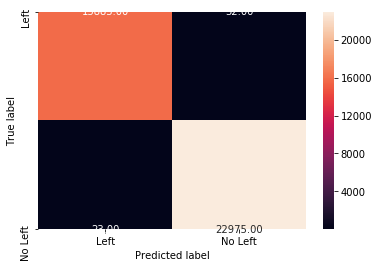

In [42]:
tree_cm = metrics.confusion_matrix( tree_test_pred.predicted,
                                 tree_test_pred.actual,[1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [54]:
#metrics.roc_auc_score( tree_test_pred.actual, tree_test_pred.predicted )

In [50]:
### metrics.roc_auc_score( tree_test_pred.actual, tree_test_pred.predicted,multi_class="ovo")

### Using Random Forest Classifier

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
pargrid_rf = {'n_estimators': np.arange(50,70),
                  'max_features': np.arange(10,14)}

#from sklearn.grid_search import GridSearchCV
gscv_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_rf, 
                        cv=5,
                        verbose=True, n_jobs=-1)

gscv_results = gscv_rf.fit(train_X, train_y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 26.5min finished


In [62]:
gscv_results.best_params_

{'max_features': 13, 'n_estimators': 67}

In [65]:
gscv_rf.best_score_

0.9987976260328393

In [66]:
radm_clf = RandomForestClassifier(oob_score=True,n_estimators=67, max_features=13, n_jobs=-1)
radm_clf.fit( train_X, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=67, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [67]:
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( test_X ) } )

In [73]:
print(metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted ))
#print(metrics.roc_auc_score( radm_test_pred.actual, radm_test_pred.predicted ))

0.9986982673489542


In [75]:
print(metrics.classification_report( radm_test_pred.actual, radm_test_pred.predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23107
           1       1.00      1.00      1.00     15926
           2       1.00      1.00      1.00      4225
           3       0.99      0.99      0.99      1260
           4       0.85      0.74      0.79        38

    accuracy                           1.00     44556
   macro avg       0.97      0.94      0.95     44556
weighted avg       1.00      1.00      1.00     44556



In [78]:
tree_cm = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,)
tree_cm

array([[23087,     6,     3,     9,     3],
       [    7, 15918,     1,     0,     0],
       [    9,     1,  4220,     2,     0],
       [    3,     1,     1,  1245,     7],
       [    1,     0,     0,     4,    28]], dtype=int64)

In [86]:
#print(radm_clf.feature_importances_)
#print(np.argsort(radm_clf.feature_importances_))

In [79]:
#Conclusion : Using random forest yielded an accuracy of 99.87%